In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import entropy

In [2]:
file_path = "/Users/optimus/.cache/kagglehub/datasets/danizo/eeg-dataset-for-adhd/versions/1/adhdata.csv"
data = pd.read_csv(file_path)

In [3]:
data.head()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T7,T8,P7,P8,Fz,Cz,Pz,Class,ID
0,261.0,402.0,16.0,261.0,126.0,384.0,126.0,236.0,52.0,236.0,...,16.0,200.0,494.0,126.0,236.0,121.0,367.0,121.0,ADHD,v10p
1,121.0,191.0,-94.0,85.0,16.0,200.0,126.0,52.0,347.0,273.0,...,-57.0,126.0,347.0,52.0,52.0,15.0,121.0,-19.0,ADHD,v10p
2,-55.0,85.0,-204.0,15.0,-57.0,200.0,52.0,126.0,236.0,200.0,...,-94.0,126.0,420.0,52.0,126.0,-55.0,261.0,85.0,ADHD,v10p
3,191.0,85.0,52.0,50.0,89.0,236.0,163.0,89.0,89.0,89.0,...,-57.0,236.0,420.0,126.0,126.0,15.0,85.0,-55.0,ADHD,v10p
4,-55.0,-125.0,-204.0,-160.0,-204.0,16.0,-241.0,-241.0,89.0,16.0,...,-131.0,89.0,310.0,-57.0,52.0,-55.0,15.0,-336.0,ADHD,v10p


In [4]:
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(f"Class distribution: {data['Class'].value_counts()}")
print(f"Number of unique patients: {data['ID'].nunique()}")

Dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Class distribution: Class
ADHD       1207069
Control     959314
Name: count, dtype: int64
Number of unique patients: 121


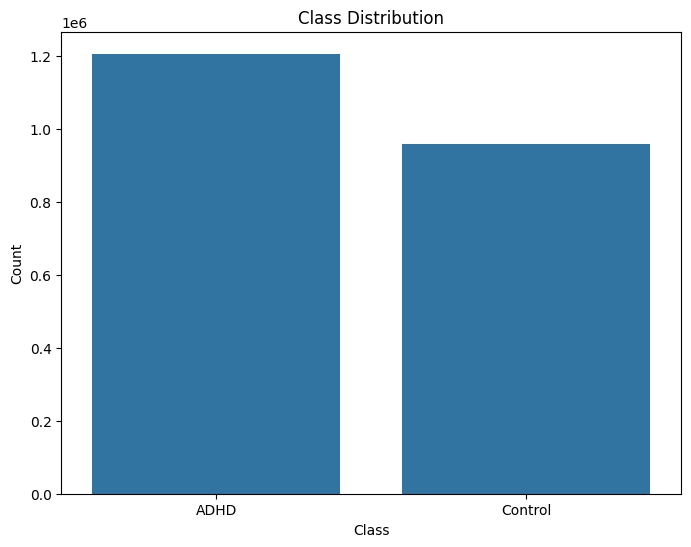

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x=data['Class'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# These are the standard frequency bands used in EEG analysis:
- Delta (0.5-4 Hz): Associated with deep sleep
- Theta (4-8 Hz): Associated with drowsiness, meditation
- Alpha (8-13 Hz): Associated with relaxation
- Beta (13-30 Hz): Associated with active thinking, focus
- Gamma (30-45 Hz): Associated with cognitive processingz

In [6]:
# Define the EEG frequency bands
freq_bands = {
    'delta': (0.5, 4),    # Delta band: 0.5-4 Hz
    'theta': (4, 8),      # Theta band: 4-8 Hz
    'alpha': (8, 13),     # Alpha band: 8-13 Hz
    'beta': (13, 30),     # Beta band: 13-30 Hz
    'gamma': (30, 45)     # Gamma band: 30-45 Hz
}


# Feature Extraction
 
 We'll extract the following features from EEG signals:
 1. Time domain features: statistical measures for each channel
 2. Frequency domain features: power in each frequency band
 3. Theta/Beta ratio: commonly used in ADHD research
 4. Entropy measures: signal complexity

In [7]:

def extract_eeg_features(patient_data, channel_names, sampling_rate=128):
    """
    Extract EEG features from a single patient's data
    
    Parameters:
    -----------
    patient_data : DataFrame
        EEG data for a single patient
    channel_names : list
        Names of EEG channels
    sampling_rate : int
        Sampling rate of the EEG data in Hz
        
    Returns:
    --------
    features : ndarray
        Extracted features vector
    """
    # Get only EEG channel data
    eeg_data = patient_data[channel_names].values
    
    # Initialize features list
    features = []
    
    # 1. Time domain features
    # Calculate statistical measures for each channel
    for i, channel in enumerate(channel_names):
        # Get channel data
        channel_data = eeg_data[:, i]
        
        # Statistical features
        features.append(np.mean(channel_data))           # Mean
        features.append(np.std(channel_data))            # Standard deviation
        features.append(np.max(channel_data))            # Maximum value
        features.append(np.min(channel_data))            # Minimum value
        features.append(np.median(channel_data))         # Median
        features.append(pd.Series(channel_data).skew())  # Skewness
        features.append(pd.Series(channel_data).kurtosis()) # Kurtosis
    
    # 2. Frequency domain features
    for i, channel in enumerate(channel_names):
        # Get channel data
        channel_data = eeg_data[:, i]
        
        # Compute power spectral density using Welch's method
        freqs, psd = signal.welch(channel_data, fs=sampling_rate, nperseg=min(256, len(channel_data)))
        
        # Calculate absolute power in each frequency band
        for band_name, (low_freq, high_freq) in freq_bands.items():
            idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
            band_power = np.sum(psd[idx_band])
            features.append(band_power)
            
        # Calculate relative power in each frequency band
        total_power = np.sum(psd)
        for band_name, (low_freq, high_freq) in freq_bands.items():
            idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
            band_power = np.sum(psd[idx_band])
            rel_band_power = band_power / total_power if total_power > 0 else 0
            features.append(rel_band_power)
            
        # Add band power ratios (commonly used in ADHD EEG analysis)
        # Theta/Beta ratio (typically higher in ADHD)
        theta_idx = np.logical_and(freqs >= 4, freqs <= 8)
        theta_power = np.sum(psd[theta_idx])
        
        beta_idx = np.logical_and(freqs >= 13, freqs <= 30)
        beta_power = np.sum(psd[beta_idx])
        
        theta_beta_ratio = theta_power / beta_power if beta_power > 0 else 0
        features.append(theta_beta_ratio)
    
    # 3. Entropy measures for each channel (complexity measure)
    for i in range(eeg_data.shape[1]):
        channel_data = eeg_data[:, i]
        # Shannon entropy
        hist, _ = np.histogram(channel_data, bins=20)
        hist = hist / np.sum(hist)
        channel_entropy = entropy(hist)
        features.append(channel_entropy)
    
    return np.array(features)

## Extract Features for All Patients

In [9]:
# Extract EEG channel names
channel_names = data.columns.tolist()
channel_names.remove('Class')
channel_names.remove('ID')

# Get unique patient IDs
patient_ids = data['ID'].unique()
print(f"Number of unique patients: {len(patient_ids)}")

# Initialize feature matrix and labels
X = []
y = []

# Extract features for each patient
print("Extracting features for each patient...")
for patient_id in patient_ids:
    patient_data = data[data['ID'] == patient_id]
    
    # Skip patients with very little data
    if len(patient_data) < 10:
        print(f"Skipping patient {patient_id} due to insufficient data")
        continue
    
    # Extract features
    features = extract_eeg_features(patient_data, channel_names)
    X.append(features)
    
    # Get label (assuming all rows for a patient have the same label)
    label = patient_data['Class'].iloc[0]
    label_numeric = 1 if label == 'ADHD' else 0
    y.append(label_numeric)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Handle any NaN or infinite values
if np.isnan(X).any() or np.isinf(X).any():
    print("Warning: NaN or infinite values detected in features. Replacing with zeros.")
    X = np.nan_to_num(X)

print(f"Feature matrix shape: {X.shape}")
print(f"Class distribution: ADHD={np.sum(y)}, Control={len(y)-np.sum(y)}")


Number of unique patients: 121
Extracting features for each patient...
Feature matrix shape: (121, 361)
Class distribution: ADHD=61, Control=60


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")



Training set shape: (96, 361)
Testing set shape: (25, 361)


In [22]:
# create SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))  # SVM with RBF kernel
])


In [23]:
print("Training SVM model...")
svm_pipeline.fit(X_train, y_train)

Training SVM model...


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(probability=True, random_state=42))])

In [28]:
# Make predictions
y_pred = svm_pipeline.predict(X_test)
y_pred_proba = svm_pipeline.predict_proba(X_test)[:, 1]

In [25]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Control', 'ADHD'])
conf_matrix = confusion_matrix(y_test, y_pred)


In [26]:
print(f"SVM Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

SVM Model Accuracy: 0.5200

Classification Report:
              precision    recall  f1-score   support

     Control       0.50      0.50      0.50        12
        ADHD       0.54      0.54      0.54        13

    accuracy                           0.52        25
   macro avg       0.52      0.52      0.52        25
weighted avg       0.52      0.52      0.52        25



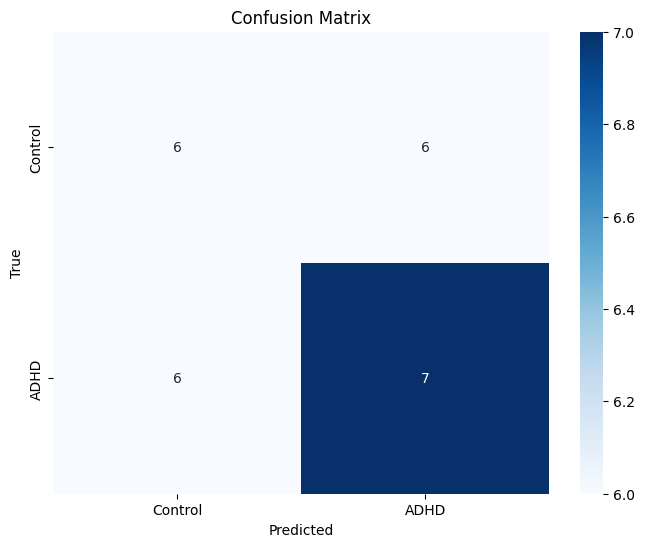

In [27]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Control', 'ADHD'], 
            yticklabels=['Control', 'ADHD'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

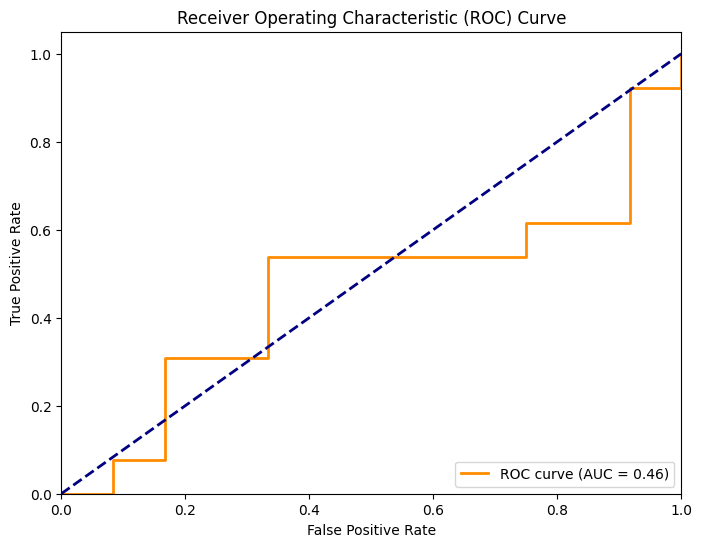

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [31]:
def predict_adhd(model, patient_data, channel_names):
    """
    Predict if a patient has ADHD based on their EEG data
    
    Parameters:
    -----------
    model : sklearn Pipeline
        Trained SVM classifier
    patient_data : DataFrame
        EEG data for a single patient
    channel_names : list
        Names of EEG channels
        
    Returns:
    --------
    prediction : int
        1 for ADHD, 0 for Control
    probability : float
        Probability of ADHD
    """
    # Extract features
    features = extract_eeg_features(patient_data, channel_names)
    features = features.reshape(1, -1)  # Reshape for single sample prediction
    
    # Make prediction
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0, 1]  # Probability of ADHD
    
    return prediction, probability

In [34]:
# print all unique ids
print(data['ID'].unique())

['v10p' 'v12p' 'v14p' 'v15p' 'v173' 'v18p' 'v19p' 'v1p' 'v20p' 'v21p'
 'v22p' 'v24p' 'v25p' 'v27p' 'v28p' 'v29p' 'v30p' 'v31p' 'v32p' 'v33p'
 'v34p' 'v35p' 'v36p' 'v37p' 'v38p' 'v39p' 'v3p' 'v40p' 'v6p' 'v8p' 'v177'
 'v179' 'v181' 'v183' 'v190' 'v196' 'v198' 'v200' 'v204' 'v206' 'v209'
 'v213' 'v215' 'v219' 'v227' 'v231' 'v234' 'v236' 'v238' 'v244' 'v246'
 'v250' 'v254' 'v263' 'v265' 'v270' 'v274' 'v279' 'v284' 'v286' 'v288'
 'v107' 'v108' 'v109' 'v110' 'v111' 'v112' 'v113' 'v114' 'v115' 'v116'
 'v41p' 'v42p' 'v43p' 'v44p' 'v45p' 'v46p' 'v47p' 'v48p' 'v49p' 'v50p'
 'v51p' 'v52p' 'v53p' 'v54p' 'v55p' 'v56p' 'v57p' 'v58p' 'v59p' 'v60p'
 'v117' 'v118' 'v120' 'v121' 'v123' 'v125' 'v127' 'v129' 'v131' 'v133'
 'v134' 'v138' 'v140' 'v143' 'v147' 'v149' 'v151' 'v297' 'v298' 'v299'
 'v300' 'v302' 'v303' 'v304' 'v305' 'v306' 'v307' 'v308' 'v309' 'v310']


In [ ]:
test_id = 'v304'  # Example ID
test_patient = data[data.ID == test_id]

actual_class = test_patient['Class'].iloc[0]
pred, prob = predict_adhd(svm_pipeline, test_patient, channel_names)

print(f"Test patient ID: {test_id}")
print(f"Actual class: {actual_class}")
print(f"Predicted class: {'ADHD' if pred == 1 else 'Control'}")
print(f"Probability of ADHD: {prob:.4f}")


Test patient ID: v304
Actual class: Control
Predicted class: Control
Probability of ADHD: 0.0572


Time domain features are based on Mohammadi et al. (2016), who used statistical features for EEG classification of ADHD children
Frequency domain features reference Barry et al. (2003) and Lenartowicz & Loo (2014), which are key papers on EEG spectral analysis in ADHD
Theta/Beta ratio citations include Snyder & Hall (2006) and Arns et al. (2013), which are seminal meta-analyses showing the significance of this ratio in ADHD
Entropy measures reference Sadatnezhad et al. (2011) and Bosl et al. (2018), which explored signal complexity metrics for neurodevelopmental disorders